In [1]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import gc, os
import pickle
import warnings
import multiprocessing as mp
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt 

# 节省内存的一个函数
# 减少内存
def reduce_mem(df):
    starttime = time.time()
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if pd.isnull(c_min) or pd.isnull(c_max):
                continue
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('-- Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction),time spend:{:2.2f} min'.format(end_mem,100*(start_mem-end_mem)/start_mem,(time.time()-starttime)/60))
    return df

# 自然时间 为一天
def ntl(group_df,time_n):
    time_c = 0
    vid_number = -1
    for i in range(len(group_df)):
        time_c += group_df.iloc[i].time_gap 
        if time_c >= time_n:
            vid_number = i 
            break 
    if vid_number == -1:
        return group_df 
    elif vid_number == 0:
        return group_df.head(2)
    else: 
        return group_df.head(vid_number+1)

In [2]:
data_path = './data_v2/'
save_path = './5000_sample/'
pd.set_option('display.max_columns', None)

# 预处理

In [3]:
vid_info = pd.read_csv(data_path + 'vid_info.csv')
candidate_items = pd.read_csv(data_path + 'candidate_items_A.csv')
seq_train = pd.read_csv(data_path + 'main_vv_seq_train.csv')

vid_info = reduce_mem(vid_info)
candidate_items = reduce_mem(candidate_items)
seq_train = reduce_mem(seq_train)

# 视频库标签编码 , 这里的 训练和测试都一样
data_did_lb = LabelEncoder()
vid_info_lb = LabelEncoder()
cid_info_lb = LabelEncoder()

seq_train['did'] = data_did_lb.fit_transform(seq_train[['did']])

vid_info['vid'] = vid_info_lb.fit_transform(vid_info[['vid']])
vid_info['cid'] = cid_info_lb.fit_transform(vid_info[['cid']])

seq_train['vid'] = vid_info_lb.transform(seq_train[['vid']])
candidate_items['vid'] = vid_info_lb.transform(candidate_items[['vid']])

vid_info['stars'] = vid_info['stars'].apply(eval)
vid_info['tags'] = vid_info['tags'].apply(eval)
vid_info['key_word'] = vid_info['key_word'].apply(eval)

vid_info['stars'] = vid_info['stars'].apply(set)
vid_info['tags'] = vid_info['tags'].apply(set)
vid_info['key_word'] = vid_info['key_word'].apply(set)

# 获取当前数据的历史点击和最后一次点击
def get_test_train(train_):
    
    train_.sort_values(by=['did','seq_no'],inplace=True,ascending=False)
    train_['site'] =  train_.groupby('did').cumcount()+1
    
    local_final_log = train_[train_['site'] == 1].reset_index(drop=True)
    train_d = train_[train_['site'] != 1].reset_index(drop=True)

    del local_final_log['site']
    del train_d['site']

    return local_final_log,train_d

# 划分数据集
local_final_log,train_data = get_test_train(seq_train.copy()) 
all_data = seq_train 

del seq_train
print(all_data.shape,train_data.shape)

-- Mem. usage decreased to  7.56 Mb (44.8% reduction),time spend:0.00 min
-- Mem. usage decreased to  0.10 Mb (0.0% reduction),time spend:0.00 min
-- Mem. usage decreased to 154.78 Mb (54.7% reduction),time spend:0.01 min
(5596413, 8) (5425504, 8)


In [4]:
# train_data_7 = train_data.groupby('did',group_keys=False).apply(ntl,time_n = 1209600)
# train_data_7 = train_data_7.sort_values(by=['did','seq_no'],ascending=False)

train_data_7 = pd.read_csv(save_path + 'train_data_7.csv')

all_data_7 = pd.concat((train_data_7,local_final_log),axis=0)
all_data_7 = all_data_7.sort_values(by=['did','seq_no'],ascending=False)

# train_data_7.to_csv(save_path + 'train_data_7.csv',index=False)

## 工程第一个步骤

In [11]:
def recall_data(data,vid_info_,candidate_items_,log):
    # debug 
##################################################################################################################
    data = data.merge(vid_info_[['vid','cid']],on='vid',how='left')
    # 计算用户 cid 的累计,包括视频的反复观看
    tmp = data.groupby(['did','cid']).size().sort_values(ascending=False).reset_index()
    tmp.columns = ['did','cid','cid_count']
    data = data.merge(tmp,on=['did','cid'],how='left')
    del tmp 
    # 用户序列的下一个观看
    data['next_vid'] = data.groupby(['did']).vid.shift(1)
##################################################################################################################
    print("———————————————————————— 候选视频序列字典 ——————————————————————")
    vid_info_cand = vid_info_[vid_info_.vid.isin(candidate_items_.vid.unique())]
    vid_info_cand['vid_pop'] = vid_info_cand['vid'].map(data.vid.value_counts())
    vid_info_cand.rename(columns={'vid':'candi_vid'},inplace=True)
    vid_info_cand = vid_info_cand.fillna(0)
    # 候选视频列表列
    cid_action = dict()
    for cid, cid_v in tqdm(vid_info_cand.groupby('cid')):
        cid_action[cid] = cid_v['candi_vid']
    # 把新闻的这个给剔除了，没有序列信息，嘻嘻
    del cid_action[1384]
    # print("———————————————————————— fpn页面筛选序字典 ——————————————————————") 作为特征可以，召回不行
    # data_fpn = data[data['fpn'] != 130]
    # data_fpn['next_vid'] = data_fpn.groupby('did').vid.shift(1) 
    # fpn_habit = data_fpn.groupby(['vid','next_vid']).size().sort_values(ascending=False).reset_index()
    # fpn_habit = fpn_habit[fpn_habit.next_vid.isin(candidate_items.vid.unique())]
    # fpn_habit.rename(columns={0:'sta_score','next_vid':'candi_vid'},inplace=True)

    # fpn_action = dict() 
    # for vid,cand in tqdm(fpn_habit.groupby('vid')):
    #     fpn_action[vid] = cand['candi_vid']

    print("_______________________ 召回序列行为字典**最重要的** _______________________")
    ################### 规则一号 ####################
    vid_habit = data.groupby(['vid','next_vid']).size().sort_values(ascending=False).reset_index()
    vid_habit = vid_habit[vid_habit.next_vid.isin(candidate_items_.vid.unique())]
    vid_habit.sort_values(by=['vid','next_vid',0],ascending=False)
    vid_habit.rename(columns={0:'sta_score','next_vid':'candi_vid'},inplace=True)
    # vid_habit = vid_habit.merge(vid_info[['vid','cid']],on='vid',how='left')
    # 规则字典
    vid_action = dict()
    for vid,cand in tqdm(vid_habit.groupby('vid')):
        vid_action[vid] = cand['candi_vid']
    # 热度视频
    hot_200 = vid_info_cand.sort_values(by=['vid_pop'],ascending=False).head(200).reset_index(drop=True)['candi_vid']
##################################################################################################################
    ## 召回的字典格式转化为 pd 
    def user_cid_recall_df_func(recall_df,did_df):
        print(" —————————————————————————— 召回字典转换为 pd ——————————————————————————")
        user_did = did_df.did.unique()
        user_cid_recall_list = []
        for i in tqdm(range(len(user_did))):
            did = user_did[i]
            recall_ = recall_df[did]
            for j in range(len(recall_)):
                user_cid_recall_list.append((did,recall_.iloc[j]))
        user_cid_recall_df = pd.DataFrame(user_cid_recall_list,columns=['did','candi_vid'])
        return user_cid_recall_df

    ## 检查训练数据的合集召回的候选集命中率
    def user_cid_recall_hit_score_func(recall_dict,valid):
        print("——————————————————————————— 召回集击中率模块 ————————————————————————————")
        hit_total = 0
        sample_n = 0
        total = valid.shape[0]
        for i in tqdm(range(len(valid))):
            local_valid_vid = valid.iloc[i].vid
            local_valid_did = valid.iloc[i].did  
            candi_vid = recall_dict[local_valid_did]
            if local_valid_vid in candi_vid.values: 
                hit_total += 1
        print(hit_total / total)
##################################################################################################################
    # 似乎处于追剧模式下的用户，单纯序列就已经可以满足了，刷视频的用户，在历史中占据一条时木有用的，但如果他对该条视频累计观看时间超过了某个百分比，也进行推荐
    # 而候选视频在 日志文件的下一个统计里面时最好的，不需要在频繁筛选
    def rr(his):
        recall = pd.Series()
        # 策略 1、用户前一条视频推荐 ，保证序列性, 但对新的视频可能不是很好
        last = his.iloc[0] 
        last_vid = last.vid 
        if last_vid in vid_action: 
            recall = recall.append(vid_action[last_vid][~vid_action[last_vid].isin(his['vid'].unique())].head(50))

        # 策略 2、历史更新视频召回，保证序列有效性，这里cid_count 需要做一个巧妙的计算，这是必须的，因为很多在日志文件里面没有找到, 还给你看这个，我全部给你召了，最多不就是 157 吗，给你办了
        user_h = his[his['cid_count'] >= 2]
        user_h = user_h.groupby('cid').head(1)
        for i in range(len(user_h)):
            vid_ = user_h.iloc[i].vid 
            if vid_ in vid_action:
                vid_A = vid_action[vid_]
                recall = recall.append(vid_A[~vid_A.isin(his['vid'].unique())].head(10))
                
        # # 策略 3、候选视频在日志文件中的热度 对低活跃用户补充
        if len(his) < 20:
            recall = recall.append(hot_200[~hot_200.isin(his['vid'].unique())].head(20))
        # 策略 4、召回的太少了，就从热门视频中找 10 条
        if len(recall) < 50:
            recall = recall.append(hot_200[~hot_200.isin(his['vid'].unique())].head(50 - len(recall)))

        recall = recall.drop_duplicates()
        return recall
##################################################################################################################
    def user_cid_recall_dict_func(user_hist_watch,vid_info_cand):
        print("—————————————————————————— 召回模块 ————————————————————————")
        user_cid_recall = dict()
        user_hist_watch = user_hist_watch.sort_values(by=['did','seq_no'],ascending=False)
        for did, hist in tqdm(user_hist_watch.groupby('did')):
            user_cid_recall[did] = rr(hist)
        return user_cid_recall

    gc.collect()
    # # 本地数据召回
    data_recall = user_cid_recall_dict_func(data,vid_info_cand)
    # # 查看击中率
    user_cid_recall_hit_score_func(data_recall,local_final_log)
    # 转化为 pd
    data_recall_df = user_cid_recall_df_func(data_recall,data)
    print(data_recall_df.shape)
##################################################################################################################
    # 给训练数据贴上标签
    # 测试数据是莫得标签滴
    print("———————————————————————————— 监督学习模块————————————————————————————")
    def get_rank_label_df(recall_df, label_df):

        local_ = label_df.rename(columns={'vid': 'candi_vid'},inplace=False)
        recall_df_ = recall_df.merge(local_[['did','candi_vid','seq_no']], how='left', on=['did','candi_vid'])
        recall_df_['label'] = recall_df_['seq_no'].apply(lambda x: 0 if np.isnan(x) else 1)
        del recall_df_['seq_no']
        return recall_df_

    data_label_df = get_rank_label_df(data_recall_df,log)
    data_label_df['candi_vid'] = data_label_df['candi_vid'].apply(int)

    data_label_df = reduce_mem(data_label_df)
    gc.collect()
    print("mo sir, !内劳人科滴票准共乘浣乘辣!")
    return data_recall

In [12]:
print(train_data_7.shape)
train_recall = recall_data(train_data_7.copy(),vid_info,candidate_items,local_final_log)

(5415478, 8)
———————————————————————— 候选视频序列字典 ——————————————————————


100%|██████████| 2449/2449 [00:00<00:00, 32017.19it/s]


_______________________ 召回序列行为字典**最重要的** _______________________


100%|██████████| 62566/62566 [00:02<00:00, 26018.31it/s]


—————————————————————————— 召回模块 ————————————————————————


  7%|▋         | 12635/170909 [00:48<09:43, 271.35it/s]

In [185]:
co = ['did', 'vid', 'vts', 'hb', 'seq_no', 'cpn', 'fpn', 'time_gap', 'cid',
       'is_intact', 'serialno', 'classify_id', 'series_id', 'duration',
       'title_length','cid_count']

5560053	1097	61764	109.0	137.0	34.0	10	130	41.0	6200	1	412	1	19033	174	79	1	6
5560054	1097	59629	36.0	34.0	33.0	10	130	46.0	6215	2	27	1	103541	42	72	1	1003
5560055	1097	22133	25.0	69.0	32.0	10	130	2447.0	2852	3	1	1	106327	92	77	1	4

In [186]:
all_data_7 = all_data_7.merge(vid_info[['vid','cid']],on='vid',how='left')
tmp = all_data_7.groupby(['did','cid']).size().sort_values(ascending=False).reset_index()
tmp.columns = ['did','cid','cid_count']
all_data_7 = all_data_7.merge(tmp,on=['did','cid'],how='left')
del tmp
del all_data_7['cid']

In [187]:
trr = all_data_7.merge(vid_info,on='vid',how='left')[co]
tr = trr.groupby('did').head(3)
tr = tr.sort_values(by=['did','seq_no'],ascending=False)
t = tr.groupby('did')['cid'].apply(lambda x: x.iloc[1] == x.iloc[2])
t = t[t.values == False].index
t

Int64Index([     2,      3,      4,      5,      7,      8,     11,     13,
                14,     16,
            ...
            170889, 170891, 170892, 170893, 170894, 170896, 170900, 170904,
            170905, 170907],
           dtype='int64', name='did', length=84155)

In [295]:
# 等下不用 classify_id 和 series_id 的相似性了
a1 = tr[~tr.did.isin(t)]

In [397]:
did = np.random.choice(a1.did.unique())
print(all_data[all_data['did'] == did].shape)
print(all_data_7[all_data_7['did'] == did].shape)
a1[a1['did'] == did]

(6, 8)
(6, 9)


,did,vid,vts,hb,seq_no,cpn,fpn,time_gap,cid,is_intact,serialno,classify_id,series_id,duration,title_length,cid_count
4742309,25824,21123,2430.0,5156.0,6.0,1,68,109430.0,1260,1,13,1,0,5396,90,1
4742310,25824,134599,5090.0,5012.0,5.0,1,68,98.0,3751,1,49,1,106049,5241,90,5
4742311,25824,111948,11.0,8.0,4.0,1,68,61738.0,3751,1,50,1,106049,1493,120,5


In [398]:
trr[trr['did'] == did].head(20)

,did,vid,vts,hb,seq_no,cpn,fpn,time_gap,cid,is_intact,serialno,classify_id,series_id,duration,title_length,cid_count
4742309,25824,21123,2430.0,5156.0,6.0,1,68,109430.0,1260,1,13,1,0,5396,90,1
4742310,25824,134599,5090.0,5012.0,5.0,1,68,98.0,3751,1,49,1,106049,5241,90,5
4742311,25824,111948,11.0,8.0,4.0,1,68,61738.0,3751,1,50,1,106049,1493,120,5
4742312,25824,71171,4560.0,4600.0,3.0,1,130,41058.0,3751,1,45,1,106049,4739,102,5
4742313,25824,50601,451.0,4640.0,2.0,1,130,158819.0,3751,1,41,1,106049,4797,115,5
4742314,25824,51079,862.0,781.0,1.0,1,130,NaN,3751,1,48,1,106049,956,102,5


In [219]:
vid_info_[(vid_info_['cid'] == 5982) & (vid_info_['serialno'] >= 39)]

,vid,cid,is_intact,serialno,classify_id,series_id,duration,title_length,upgc_flag,stars,tags,key_word
148492,46692,5982,3,39,2,0,90,96,0,{},{},"{418448, 316405, 316403, 483852, 611715, 84913..."
149093,41566,5982,3,40,2,0,91,93,0,{},{},"{418448, 324194, 316405, 316403, 483852, 61171..."
149094,92764,5982,2,39,2,0,157,55,0,"{101002592, 101003972, 101001892, 101003559}",{},"{418448, 316405, 316403, 483852, 611715, 84913..."
149095,126943,5982,2,39,2,0,147,85,0,"{101002592, 101003972, 101001892, 101003559}",{},"{418448, 316405, 316403, 483852, 611715, 84913..."
149096,85381,5982,2,39,2,0,152,43,0,"{101002592, 101003972, 101001892, 101003559}",{},"{418448, 316405, 316403, 483852, 611715, 84913..."
149097,66444,5982,1,39,2,0,2739,21,0,"{101002592, 101003972, 101001892, 101003559}",{},"{418448, 316405, 316403, 483852, 611715, 84913..."
149567,64286,5982,2,40,2,0,180,39,0,"{101002592, 101001892, 101003972, 101003559, 1...",{},"{418448, 324194, 316405, 316403, 483852, 61171..."
149568,140241,5982,2,40,2,0,181,51,0,"{101002592, 101023618, 101003972, 101001892, 1...",{},"{418448, 316405, 316403, 565490, 611715, 84913..."
149569,128193,5982,2,40,2,0,148,73,0,"{101002592, 101003972, 101001892, 101003559}",{},"{418448, 316405, 316403, 483852, 611715, 84913..."
149576,28542,5982,1,40,2,0,2792,21,0,"{101002592, 101003972, 101001892, 101003559}",{},"{418448, 316405, 316403, 483852, 611715, 84913..."


In [220]:
# vid_habit[(vid_habit['vid'] == 41731) & (vid_habit['cid'] == 6465)].head(30)
vid_habit[(vid_habit['vid'] == 66444)].head(10)

,vid,candi_vid,sta_score,cid
108,66444,41566.0,3747,5982
196,66444,28542.0,1846,5982
1050,66444,108201.0,482,5982
2860,66444,7358.0,182,5982
4083,66444,121136.0,125,5982
4447,66444,78186.0,113,5982
5846,66444,139535.0,81,5982
6405,66444,128217.0,73,5982
7787,66444,37949.0,58,5982
8016,66444,43364.0,56,5982


# 从用户的日志数据中找到有用的特征
fpn 68 （这个我猜测是刷段视频的页面 ，所有视频合集会不连续) 大部分都是低的，果然时短剧
fpn 105
fpn 139 对视频的热度不是很感冒

cpn-fpn：1-130 是最多的 ，在训练模型的时候也显示了重要性

fpn 130 可能是平台观看视频的主页，找视频的，主要聚集在这里
fpn 73 也有 33496的热度？
删掉 hb 比例少的用户

In [ ]:
## 提议的特征处理 是对每条召回的视频做特征，不是对用户本身的日志数据做特征合并
# 1、单纯的 wr 和 fr 是很有奏效的
# 2、召回的列表和最近的两条视频 时长做均值 标题长度做均值
# 用户看得少，热度越有用 用户看得多 热度越没用 vid_pop / user_watch_vid_n 
# 间隔时间越长 热度显示越显著
# 用户观看越多，视频热度效益越少
# 该合集是否被看完，做类别特征
# 视频有效观看越少，对合集的喜爱长度越少
# fpn 对视频做统计 ：这里用上全部的数据


# 等下看看 68 页面的都是什么视频
# 视频时长和视频热度是衡量用户观看习惯的两个重要指标
# 召回时，不仅仅根据 下一视频统计，也更具页面统计召回
# 现在我并不觉得 classify_id 和 series_id 有多么重要了
# 筛选 fpn 的页面 做统计
# 130 主页 68 刷视频页
# 不仅从 最后一个序列 也有前面几条的序列

In [77]:
print("———————————————————— 一阶用户特征抽取 ——————————————————————")
# 一、数值类型特征
def value_feature(data_,data_recall_,vid_info_):
    data_ = data_.merge(vid_info_,on='vid',how='left')

    data_recall_ = data_recall_.merge(vid_info_[['vid','duration','title_length']],left_on='candi_vid',right_on='vid',how='left')
    # 候选视频在日志文件中的热度
    data_recall_['vid_pop'] = data_recall_['candi_vid'].map(data_['vid'].value_counts())
    data_recall_.fillna(0)

    data_['vid_pop'] = data_['vid'].map(data_.vid.value_counts())

    cols = ['did','seq_no','vts','hb','duration','title_length','vid_pop']
    data_ = data_[cols]
    gc.collect()
    data_ = reduce_mem(data_)
    
    data_ = data_.sort_values(by=['did','seq_no'],ascending=False)
    data_['wr'] = data_['vts'] / data_['duration']
    data_['fr'] = data_['hb'] / data_['duration']
    # 所有用户日志做成一个列表
    data_ = data_.groupby('did').agg(list).reset_index()

    data_['dura_mean'] = data_['duration'].apply(np.mean)
    data_['dura_max'] = data_['duration'].apply(np.max)
    data_['dura_min'] = data_['duration'].apply(np.min)

    data_['vp_mean'] = data_['vid_pop'].apply(np.mean)
    data_['vp_max'] = data_['vid_pop'].apply(np.max)
    data_['vp_min'] = data_['vid_pop'].apply(np.min)

    data_['til_mean'] = data_['title_length'].apply(np.mean)

    data_['wr_l'] = data_['wr'].apply(lambda x: x[0])
    data_['fr_l'] = data_['fr'].apply(lambda x: x[0])

    data_ = data_[['did','dura_mean','dura_max','dura_min','vp_mean','vp_max','vp_min','til_mean','wr_l','fr_l']]    # 11
    data_recall_ = data_recall_.merge(data_,on='did',how='left')
    del data_recall_['vid']
    del data_recall_['label']
    data_recall_ = reduce_mem(data_recall_)

    return data_recall_

# 二、数值类型特征列
train_val_f = value_feature(train_data_7,train_recall,vid_info)
train_val_f.head(1)

———————————————————— 一阶用户特征抽取 ——————————————————————
-- Mem. usage decreased to 87.45 Mb (13.3% reduction),time spend:0.00 min
-- Mem. usage decreased to 357.22 Mb (47.6% reduction),time spend:0.01 min


,did,candi_vid,duration,title_length,vid_pop,dura_mean,dura_max,dura_min,vp_mean,vp_max,vp_min,til_mean,wr_l,fr_l
0,170908,110982,1674,24,482.0,2312.0,3354,812,751.0,1869,265,23.9375,0.152466,0.958984


In [78]:
# 类别类型特征 
print('———————————————————— 一阶用户类别特征抽取 ————————————————————')
from collections import Counter
def cate_feature(data_,recall_data_,vid_info):

    data_ = data_.merge(vid_info,on='vid',how='left')
    recall_data_ = recall_data_.merge(vid_info,left_on='candi_vid',right_on='vid',how='left')

    cat_cols = ['did','seq_no','cpn','fpn','cid','is_intact','series_id','serialno','classify_id']
    cat_cols_ = ['did','candi_vid','cid','is_intact','series_id','serialno','classify_id']

    data_ = data_[cat_cols]
    recall_data_ = recall_data_[cat_cols_]

    data_ = reduce_mem(data_)
    recall_data_ = reduce_mem(recall_data_)
    gc.collect()
    
    data_ = data_.sort_values(by=['did','seq_no'],ascending=False)
    data_ = data_.groupby('did').agg(list).reset_index()

    data_['cpn'] = data_['cpn'].apply(lambda x: x[0])
    data_['fpn'] = data_['fpn'].apply(lambda x: x[0])
    
    cid_h = dict()
    isi_h = dict()
    cla_h = dict()
    upg_h = dict()
    ser_h = dict()
    for did, hist in tqdm(data_.groupby('did')):
        cid_h[did] = Counter(hist.iloc[0].cid)
        isi_h[did] = Counter(hist.iloc[0].is_intact)
        cla_h[did] = Counter(hist.iloc[0].classify_id)
        ser_h[did] = Counter(hist.iloc[0].series_id)

    print("类型特征计数开始")

    def sim_(df):
        did = df.iloc[0].did
        df['cid_s'] = df['cid'].apply(lambda x: cid_h[did][x])
        df['isi_s'] = df['is_intact'].apply(lambda x: isi_h[did][x])
        df['cla_s'] = df['classify_id'].apply(lambda x: cla_h[did][x])
        df['ser_s'] = df['series_id'].apply(lambda x: ser_h[did][x])
        return df[['cid_s','isi_s','cla_s','ser_s']]
        
    recall_data_[['cid_s','isi_s','cla_s','ser_s']] = recall_data_.groupby('did',group_keys=False).apply(sim_)
    gc.collect()
    recall_data_ = recall_data_.merge(data_[['did','cpn','fpn']],on='did',how='left')

    recall_data_ = recall_data_[['did','candi_vid','cid','is_intact','series_id','serialno','classify_id','cpn','fpn','cid_s','isi_s','cla_s','ser_s']]
    recall_data_ = reduce_mem(recall_data_)
    return recall_data_

# 先选择 最近 4 小时的数据
train_cat_f = cate_feature(train_data_7,train_recall,vid_info)
train_cat_f

———————————————————— 一阶用户类别特征抽取 ————————————————————
-- Mem. usage decreased to 90.82 Mb (6.9% reduction),time spend:0.00 min
-- Mem. usage decreased to 211.09 Mb (7.1% reduction),time spend:0.00 min


100%|██████████| 170909/170909 [00:56<00:00, 3037.32it/s]


类型特征计数开始
-- Mem. usage decreased to 300.39 Mb (50.0% reduction),time spend:0.01 min


,did,candi_vid,cid,is_intact,series_id,serialno,classify_id,cpn,fpn,cid_s,isi_s,cla_s,ser_s
0,170908,110982,7065,1,0,31,2,1,26,29,49,51,51
1,170908,91705,7065,1,0,32,2,1,26,29,49,51,51
2,170908,101939,7065,1,0,34,2,1,26,29,49,51,51
3,170908,143981,7065,1,0,35,2,1,26,29,49,51,51
4,170908,98102,7065,1,0,33,2,1,26,29,49,51,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8513072,0,42185,1943,4,0,8,2,1,130,0,0,0,0
8513073,0,110245,6974,1,51680,36,1,1,130,3,3,3,3
8513074,0,4913,6974,1,51680,1,1,1,130,3,3,3,3
8513075,0,71967,1943,1,0,8,2,1,130,0,3,0,0


In [79]:
# 这个要改改 Counter
print(" —————————————————————————————— 一阶标签特征抽取 ——————————————————————————————")
def lab_feature(data_,recall_data_,vid_info):
    combine = lambda bt : {i for p in bt for i in p}

    data_ = data_.merge(vid_info,on='vid',how='left')
    recall_data_ = recall_data_.merge(vid_info,left_on='candi_vid',right_on='vid',how='left')
    lab_cols = ['did','stars','key_word','tags']
    lab_cols_ = ['did','candi_vid','stars','key_word','tags']

    data_ = data_[lab_cols]
    recall_data_ = recall_data_[lab_cols_]
    
    data_ = reduce_mem(data_)
    recall_data_ = reduce_mem(recall_data_)
    gc.collect()

    data_ = data_.groupby('did').agg(list).reset_index()

    data_['stars'] = data_['stars'].apply(combine)
    data_['tags'] = data_['tags'].apply(combine)
    data_['key_word'] = data_['key_word'].apply(combine)

    data_.rename(columns={'stars':'L_stars','tags':'L_tags','key_word':'L_key_word'},inplace=True)
    recall_data_ = recall_data_.merge(data_[['did','L_stars','L_tags','L_key_word']],on='did',how='left')

    def sim_score(gd1,gd2):
        return len(gd1 & gd2)
    recall_data_['stars_sim'] = recall_data_.apply(lambda row: sim_score(row['stars'],row['L_stars']),axis=1)
    recall_data_['tags_sim'] = recall_data_.apply(lambda row: sim_score(row['tags'],row['L_tags']),axis=1)
    recall_data_['key_word_sim'] = recall_data_.apply(lambda row: sim_score(row['key_word'],row['L_key_word']),axis=1)

    recall_data_ = recall_data_[['did','candi_vid','stars_sim','tags_sim','key_word_sim']]
    recall_data_ = reduce_mem(recall_data_)
    gc.collect()
    return recall_data_

# 标签类型特征,这个只能是最近4小时
train_lab_f = lab_feature(train_data_7,train_recall,vid_info)
train_lab_f

 —————————————————————————————— 一阶标签特征抽取 ——————————————————————————————
-- Mem. usage decreased to 121.09 Mb (0.0% reduction),time spend:0.00 min
-- Mem. usage decreased to 324.75 Mb (0.0% reduction),time spend:0.00 min
-- Mem. usage decreased to 162.37 Mb (50.0% reduction),time spend:0.00 min


,did,candi_vid,stars_sim,tags_sim,key_word_sim
0,170908,110982,5,28,10
1,170908,91705,5,23,10
2,170908,101939,5,34,10
3,170908,143981,5,36,10
4,170908,98102,5,23,10
...,...,...,...,...,...
8513072,0,42185,0,0,0
8513073,0,110245,7,0,10
8513074,0,4913,5,0,8
8513075,0,71967,0,0,0


In [82]:
def stat_feature(data_,recall_data_,vid_info_,candidate_items_):

    data_['next_vid'] = data_.groupby(['did']).vid.shift(1)
    data_ = data_.merge(vid_info,on='vid',how='left')
    d_ = data_.groupby('did').head(1)
    recall_data_ = recall_data_.merge(d_[['did','vid','cid','fpn']],on='did',how='left')
    data_ = data_.sort_values(by=['did','seq_no'],ascending=False)
    # 特征处理列
    sta_cols = ['did','vid','next_vid','cid','fpn']
    sta_cols_ = ['did','vid','cid','candi_vid','fpn']

    data_ = data_[sta_cols]
    recall_data_ = recall_data_[sta_cols_]

    print("———————————————————————————— 我的无敌四大法宝 ——————————————————————————")
    ################### 规则一号
    vid_habit = data_.groupby(['vid','next_vid']).size().sort_values(ascending=False).reset_index()
    vid_habit = vid_habit[vid_habit.next_vid.isin(candidate_items_.vid.unique())]
    vid_habit.rename(columns={0:'sta_score','next_vid':'candi_vid'},inplace=True)

    #################### 规则三号
    # cpn_habit = data_.groupby(['cpn','vid','next_vid']).size().sort_values(ascending=False).reset_index()
    # cpn_habit = cpn_habit[cpn_habit.next_vid.isin(candidate_items_.vid.unique())]
    # cpn_habit.rename(columns={0:'cpn_score','next_vid':'candi_vid'},inplace=True)

    fpn_habit = data_.groupby(['fpn','vid','next_vid']).size().sort_values(ascending=False).reset_index()
    fpn_habit = fpn_habit[fpn_habit.next_vid.isin(candidate_items_.vid.unique())]
    fpn_habit.rename(columns={0:'fpn_score','next_vid':'candi_vid'},inplace=True)


    recall_data_ = recall_data_.merge(vid_habit,on=['vid','candi_vid'],how='left')

    recall_data_ = recall_data_.merge(fpn_habit,on=['fpn','vid','candi_vid'],how='left')

    recall_data_ = recall_data_.fillna(0)
    recall_data_ = recall_data_[['did','candi_vid','sta_score','fpn_score']]

    recall_data_ = reduce_mem(recall_data_)
    gc.collect()
    return recall_data_

train_sta_f = stat_feature(train_data_7,train_recall,vid_info,candidate_items)
train_sta_f.head(2)

———————————————————————————— 我的无敌四大法宝 ——————————————————————————
-- Mem. usage decreased to 162.37 Mb (37.5% reduction),time spend:0.00 min


,did,candi_vid,sta_score,fpn_score
0,170908,110982,408.0,37.0
1,170908,91705,8.0,0.0


In [96]:
# 线下测试数据
train_f = train_recall.merge(train_val_f,on=['did','candi_vid'],how='left')
train_f = train_f.merge(train_cat_f,on=['did','candi_vid'],how='left')
train_f = train_f.merge(train_lab_f,on=['did','candi_vid'],how='left')
train_f = train_f.merge(train_sta_f,on=['did','candi_vid'],how='left')
train_f = reduce_mem(train_f)
# 线上提交数据

-- Mem. usage decreased to 771.28 Mb (0.0% reduction),time spend:0.03 min


In [97]:
train_f.head(1)

,did,candi_vid,label,duration,title_length,vid_pop,dura_mean,dura_max,dura_min,vp_mean,vp_max,vp_min,til_mean,wr_l,fr_l,cid,is_intact,series_id,serialno,classify_id,cpn,fpn,cid_s,isi_s,cla_s,ser_s,stars_sim,tags_sim,key_word_sim,sta_score,fpn_score,seq_cpn_same,seq_fpn_same,seq_time_diff,seq_wr_favor,seq_fr_favor,seq_cid_same,seq_intact_same,seq_serialno_up,seq_classify_same,seq_series_same,seq_dura_diff,seq_title_diff,seq_stars_same,seq_tags_same,seq_key_same
0,170908,110982,1,1674,24,482.0,2312.0,3354,812,751.0,1869,265,23.9375,0.152466,0.958984,7065,1,0,31,2,1,26,29,49,51,51,5,28,10,408.0,37.0,1,1,36.5625,0.271484,0.964355,1,1,1,1,1,56.0,0.0,5,21,10


## 二阶交叉特征

In [98]:
train_f['se_is'] = train_f['serialno'].astype('str') + '_' + train_f['is_intact'].astype('str')
train_f['is_se'] = train_f['is_intact'].astype('str') + '_' + train_f['serialno'].astype('str')
train_f['cp_fp'] = train_f['cpn'].astype('str') + '_' + train_f['fpn'].astype('str')

## 特征列的标签编码和评分的归一化

In [5]:
gc.collect()

21

In [330]:
# train_f.to_csv(save_path + 'train_lgb.csv',index=False)
train_f = pd.read_csv(save_path + 'train_lgb.csv')

In [331]:
train_f = train_f[~train_f['did'].isin(t)]

In [288]:
col = ['did','candi_vid','cpn','fpn','label','duration',
 'title_length',
 'vid_pop',
 'dura_mean',
 'dura_max',
 'dura_min',
 'vp_mean',
 'vp_max',
 'vp_min',
 'til_mean',
 'wr_l',
 'fr_l',
 'cid',
 'is_intact',
 'series_id',
 'serialno',
 'classify_id',
 'cid_s',
 'isi_s',
 'cla_s',
 'ser_s',
 'stars_sim',
 'tags_sim',
 'key_word_sim',
 'sta_score',
 'fpn_score',
 'se_is',
 'is_se',
 'cp_fp']

In [332]:
train_f = train_f[col]

In [334]:
gc.collect()
# 二阶特征组合
category_k = ['se_is','is_se','cp_fp']
for c in category_k:
    train_f[c] = train_f[c].astype('category')
train_f = reduce_mem(train_f)

-- Mem. usage decreased to 312.29 Mb (70.2% reduction),time spend:0.06 min


In [333]:
train_f.did.nunique()

84155

In [336]:
import random 
def user_train_valid(tr,va,te):
    all_num = set(train_f.did.unique())
    # 训练数据
    num1 = random.sample(all_num,tr)
    # 验证数据
    all_num = all_num.difference(num1)
    num2 = random.sample(all_num,va)
    # 测试数据
    all_num = all_num.difference(num2)
    num3 = random.sample(all_num,te)

    print(len(num1))
    print(len(num2))
    print(len(num3))
    return num1,num2,num3

num1, num2, num3 = user_train_valid(50000,15000,15000)
# num1, num2, num3 = user_train_valid(110000,30000,30909)
# 用于训练的数据
trn_data = train_f[train_f['did'].isin(num1)]
trn_data.sort_values(by=['did'],ascending=False,inplace=True) 
g_train = trn_data.groupby(['did'], as_index=False).count()["label"].values
# 用于验证的数据
val_data = train_f[train_f['did'].isin(num2)]
val_data.sort_values(by=['did'],ascending=False,inplace=True) 
g_valid = val_data.groupby(['did'], as_index=False).count()["label"].values
# # 用于测试的数据
tst_data = train_f[train_f['did'].isin(num3)] 
tst_data.sort_values(by=['did'],ascending=False,inplace=True) 

50000
15000
15000


## 之后的工作就是调参，有点累

In [292]:
def mrr6(stat_data,log,topk=6):

    stat_data = stat_data.sort_values(by=['did','pred_score'],ascending=False)
    stat_data = stat_data.groupby('did').head(topk)

    comp_dict = dict()
    for did,cand_vid in tqdm(stat_data.groupby('did')):
        comp_dict[did] = cand_vid['candi_vid']

    # 评分函数 dict()版本
    score = np.zeros(log.shape[0])

    for i in tqdm(range(len(log))):
        test_did = log.iloc[i].did
        test_vid = log.iloc[i].vid 
        
        recall_ = comp_dict[test_did]
        # mrr 评分
        for j in range(len(recall_)):
            if test_vid == recall_.iloc[j]:
                score[i] = 1/(1+j)
    # print(len(score))
    # print(np.mean(score))
    return np.mean(score)

In [293]:
def submit(submit_data,name):
    
    submit_data = submit_data.sort_values(by=['did','pred_score'],ascending=False)
    res = submit_data.groupby('did').head(6)

    res = res[['did','candi_vid','pred_score']]
    res.rename(columns={'candi_vid':'vid'},inplace=True)

    res['rank'] = res.groupby('did').cumcount()+1 
    res['vid'] = res['vid'].apply(int)
    # 标签编码还原

    res['did'] = data_did_lb.inverse_transform(res['did'])
    res['vid'] = vid_info_lb.inverse_transform(res['vid'])

    res[['did','vid','rank']].to_csv('./result/' + name,index=False)
    print('结果已保存：','./result/' + name)

In [55]:
# 有效数据列
c = ['did','candi_vid','duration','title_length','vid_pop','is_intact','series_id','serialno','classify_id','cid_s','isi_s','ser_s','stars_sim','tags_sim','key_word_sim','sta_score','fpn_score','se_is','is_se','cp_fp']

In [337]:
lgb_cols = trn_data.columns
# 不用的特征列
lgb_cols_n = ['did','candi_vid','cpn','fpn','label']

lgb_cols = [x for x in lgb_cols if x not in lgb_cols_n]
lgb_cols

['duration',
 'title_length',
 'vid_pop',
 'dura_mean',
 'dura_max',
 'dura_min',
 'vp_mean',
 'vp_max',
 'vp_min',
 'til_mean',
 'wr_l',
 'fr_l',
 'cid',
 'is_intact',
 'series_id',
 'serialno',
 'classify_id',
 'cid_s',
 'isi_s',
 'cla_s',
 'ser_s',
 'stars_sim',
 'tags_sim',
 'key_word_sim',
 'sta_score',
 'fpn_score',
 'se_is',
 'is_se',
 'cp_fp']

In [338]:
lgb_ranker = lgb.LGBMRanker(boosting_type='gbdt',
                       objective='binary',
                       num_leaves=300,
                       reg_alpha=0.5,
                       reg_lambda=0.5,
                       max_depth=21,
                       n_estimators=200,
                       subsample=0.7,
                       feature_fraction=0.7,
                       learning_rate=0.06,
                       random_state=1998,
                       n_jobs= 16,
                       )

In [339]:
# 排序模型训练 
offline = True 
if offline: 
    lgb_ranker.fit(trn_data[lgb_cols], trn_data['label'], group=g_train, 
                eval_set=[(val_data[lgb_cols], val_data['label'])], 
                eval_group= [g_valid], eval_at=[6],
                verbose=50, eval_metric=['ndcg','map'], early_stopping_rounds=50,)
else: 
    lgb_ranker.fit(trn_data[lgb_cols], trn_data['label'], group=g_train) 

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[50]	valid_0's ndcg@6: 0.725701	valid_0's map@6: 0.686941	valid_0's binary_logloss: 0.0504109
[100]	valid_0's ndcg@6: 0.728133	valid_0's map@6: 0.689292	valid_0's binary_logloss: 0.0498895
[150]	valid_0's ndcg@6: 0.729094	valid_0's map@6: 0.690072	valid_0's binary_logloss: 0.0498157
[200]	valid_0's ndcg@6: 0.728898	valid_0's map@6: 0.689843	valid_0's binary_logloss: 0.0498359


In [309]:
ttt = train_data[train_data.did.isin(t)]

In [320]:
ttt[ttt['did'] == np.random.choice(ttt.did.nunique())]

,did,vid,vts,hb,seq_no,cpn,fpn,time_gap,cid,is_intact,serialno,classify_id,series_id,duration,title_length


### 线下预测，调试

In [340]:
gc.collect()
# 模型泛化预测
tst_data['pred_score'] = lgb_ranker.predict(tst_data[lgb_cols], num_iteration=lgb_ranker.best_iteration_)
# 评分函数
tst_log = local_final_log[local_final_log['did'].isin(num3)]
mrr6(tst_data,tst_log,topk=6)

100%|██████████| 15000/15000 [00:02<00:00, 6407.60it/s]


0.35527111111111115

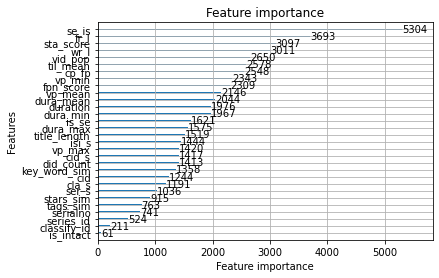

In [141]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
# 显示重要特征，max_num_features 指定显示多少个特征
plot_importance(lgb_ranker, max_num_features=50)
plt.show()

## lgb Ranker 的五折交叉验证

In [341]:
offline= False
res_path = './result/'

def get_kfold_users(trn_df, n=5):
    user_ids = trn_df['did'].unique()
    user_set = [user_ids[i::n] for i in range(n)]
    return user_set

k_fold = 5
trn_df = train_f
user_set = get_kfold_users(trn_df, n=k_fold)

score_list = []
score_df = trn_df[['did', 'candi_vid','label']]
# sub_preds = np.zeros(all_f.shape[0])

# 五折交叉验证，并将中间结果保存用于staking
for n_fold, valid_user in enumerate(user_set):
    train_idx = trn_df[~trn_df['did'].isin(valid_user)] # add slide user
    valid_idx = trn_df[trn_df['did'].isin(valid_user)]
    
    # 训练集与验证集的用户分组
    train_idx.sort_values(by=['did'], inplace=True)
    g_train = train_idx.groupby(['did'], as_index=False).count()["label"].values
    
    valid_idx.sort_values(by=['did'], inplace=True)
    g_val = valid_idx.groupby(['did'], as_index=False).count()["label"].values
    

    lgb_ranker = lgb.LGBMRanker(boosting_type='gbdt',
                        objective='binary',
                        num_leaves=300,
                        reg_alpha=0.5,
                        reg_lambda=0.5,
                        max_depth=21,
                        n_estimators=200,
                        subsample=0.7,
                        feature_fraction=0.7,
                        learning_rate=0.06,
                        random_state=1998,
                        n_jobs= 16,
                        )


    lgb_ranker.fit(train_idx[lgb_cols], train_idx['label'], group=g_train,
                   eval_set=[(valid_idx[lgb_cols], valid_idx['label'])], eval_group= [g_val], 
                   eval_at=[6], eval_metric=['ndcg','auc' ], early_stopping_rounds=50, verbose=50)

    gc.collect()
    
    valid_idx['pred_score'] = lgb_ranker.predict(valid_idx[lgb_cols], num_iteration=lgb_ranker.best_iteration_)
    

    valid_idx.sort_values(by=['did', 'pred_score'])

    score_list.append(valid_idx[['did', 'candi_vid', 'pred_score']])

    # 如果是线上测试，需要计算每次交叉验证的结果相加，最后求平均
    # if not offline:
    #     sub_preds += lgb_ranker.predict(all_f[lgb_cols], lgb_ranker.best_iteration_)
    
score_df_ = pd.concat(score_list, axis=0)
score_df = score_df.merge(score_df_, how='left', on=['did', 'candi_vid'])
    
# 测试集的预测结果，多次交叉验证求平均,将预测的score和对应的rank特征保存，可以用于后面的staking，这里还可以构造其他更多的特征
# all_f['pred_score'] = sub_preds / k_fold

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[50]	valid_0's ndcg@6: 0.69482	valid_0's auc: 0.906127	valid_0's binary_logloss: 0.0504063
[100]	valid_0's ndcg@6: 0.697086	valid_0's auc: 0.908706	valid_0's binary_logloss: 0.0498543
[150]	valid_0's ndcg@6: 0.697227	valid_0's auc: 0.908992	valid_0's binary_logloss: 0.0498099
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[50]	valid_0's ndcg@6: 0.698266	valid_0's auc: 0.907303	valid_0's binary_logloss: 0.0499095
[100]	valid_0's ndcg@6: 0.701094	valid_0's auc: 0.90957	valid_0's binary_logloss: 0.0493875
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[50]	valid_0's ndcg@6: 0.704444	valid_0's auc: 0.908145	valid_0's binary_logloss: 0.0495422
[100]	valid_0's ndcg@6: 0.706621	valid_0's auc: 0.910717	valid_0's binary_l

In [345]:
log = local_final_log[~local_final_log['did'].isin(t)]

In [346]:
# 评分函数
# mrr6(score_df,local_final_log,topk=6)
mrr6(score_df,log,topk=6)

100%|██████████| 84155/84155 [00:14<00:00, 5681.95it/s]


0.36464242568276795

## 2、LGBM 分类模型

In [146]:
# 模型及参数的定义
lgb_Classfication = lgb.LGBMClassifier(boosting_type='gbdt',objective='binary', num_leaves=301, reg_alpha=0, reg_lambda=1,
                            max_depth=21, n_estimators=100, subsample=0.7,feature_fraction=0.7,
                            learning_rate=0.06, random_state=1998, n_jobs= 16)  

In [147]:
# 模型训练
offline=True 
if offline:
    lgb_Classfication.fit(trn_data[lgb_cols], trn_data['label'],
                    eval_set=[(val_data[lgb_cols], val_data['label'])], 
                    eval_metric=['auc','logloss'], early_stopping_rounds=50,verbose=50)
else:
    lgb_Classfication.fit(trn_data[lgb_cols], trn_data['label'])

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[50]	valid_0's auc: 0.931355	valid_0's binary_logloss: 0.0460436
[100]	valid_0's auc: 0.934681	valid_0's binary_logloss: 0.0450174


In [148]:
# 模型预测
trn_data['pred_score'] = lgb_Classfication.predict_proba(trn_data[lgb_cols])[:,1]
# 评分函数
tst_log = local_final_log[local_final_log['did'].isin(num1)]
mrr6(trn_data,tst_log,topk=6)
# 模型预测
tst_data['pred_score'] = lgb_Classfication.predict_proba(tst_data[lgb_cols])[:,1]
# 评分函数
tst_log = local_final_log[local_final_log['did'].isin(num3)]
mrr6(tst_data,tst_log,topk=6)

100%|██████████| 30909/30909 [00:05<00:00, 5197.00it/s]


0.4479380331510779

## LGBClassifyer 的交叉五折验证

In [ ]:
offline=False

def get_kfold_users(trn_df, n=5):
    user_ids = trn_df['did'].unique()
    user_set = [user_ids[i::n] for i in range(n)]
    return user_set

k_fold = 5
trn_df = train_data_vid_fea
user_set = get_kfold_users(trn_df, n=k_fold)

score_list = []
score_df = trn_df[['did', 'candi_vid','label']]
sub_preds = np.zeros(all_data_vid_fea.shape[0])

# 五折交叉验证，并将中间结果保存用于staking
for n_fold, valid_user in enumerate(user_set):
    train_idx = trn_df[~trn_df['did'].isin(valid_user)] # add slide user
    valid_idx = trn_df[trn_df['did'].isin(valid_user)]
    
    # 训练集与验证集的用户分组
    train_idx.sort_values(by=['did'], inplace=True)
    g_train = train_idx.groupby(['did'], as_index=False).count()["label"].values
    
    valid_idx.sort_values(by=['did'], inplace=True)
    g_val = valid_idx.groupby(['did'], as_index=False).count()["label"].values
    

    # 模型及参数的定义
    lgb_Classfication = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=127, reg_alpha=0.0, reg_lambda=1,
                                max_depth=-1, n_estimators=100, subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
                                learning_rate=0.01, min_child_weight=50, random_state=1998, n_jobs= 16, verbose=10)  

    lgb_Classfication.fit(trn_data[lgb_cols], trn_data['label'],
                    eval_set=[(val_data[lgb_cols], val_data['label'])], 
                    eval_metric=['auc', ],early_stopping_rounds=50,)
    
    valid_idx['pred_score'] = lgb_ranker.predict(valid_idx[lgb_cols], num_iteration=lgb_ranker.best_iteration_)
    
    # 对输出结果进行归一化
    # valid_idx['pred_score'] = valid_idx[['pred_score']].transform(lambda x: norm_sim(x))
    
    valid_idx.sort_values(by=['did', 'pred_score'])

    score_list.append(valid_idx[['did', 'candi_vid', 'pred_score']])
    
    # 如果是线上测试，需要计算每次交叉验证的结果相加，最后求平均
    if not offline:
        sub_preds += lgb_ranker.predict(all_data_vid_fea[lgb_cols], lgb_ranker.best_iteration_)
    
score_df_ = pd.concat(score_list, axis=0)
score_df = score_df.merge(score_df_, how='left', on=['did', 'candi_vid'])
# 保存训练集交叉验证产生的新特征
# score_df[['did', 'candi_vid', 'pred_score', 'label']].to_csv(save_path + 'trn_lgb_ranker_feats.csv', index=False)
    
# 测试集的预测结果，多次交叉验证求平均,将预测的score和对应的rank特征保存，可以用于后面的staking，这里还可以构造其他更多的特征
all_data_vid_fea['pred_score'] = sub_preds / k_fold
# all_data_vid_fea['pred_score'] = all_data_vid_fea['pred_score'].transform(lambda x: norm_sim(x))
# all_data_vid_fea.sort_values(by=['did', 'pred_score'])
# all_data_vid_fea['pred_rank'] = all_data_vid_fea.groupby(['did'])['pred_score'].rank(ascending=False, method='first')

# 保存测试集交叉验证的新特征
# all_data_vid_fea[['did', 'candi_vid', 'pred_score']].to_csv(save_path + 'all_data_lgbRanker.csv', index=False)

In [136]:
score_df.sort_values(by=['did','pred_score'],ascending=False,inplace=True)
# 评分函数
mrr6(score_df,local_final_log,topk=6)

100%|██████████| 170909/170909 [00:36<00:00, 4654.25it/s]


170909
0.4575035057642762
